In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
from astropy import units as u
from astropy import constants as const
import numericalErrorFunctions as NEF
import datetime
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [2]:
GCdata          =   tstrippy.Parsers.baumgardtMWGCs().data
MWparams        =   tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      =   tstrippy.Parsers.potential_parameters.MWreferenceframe()
x,y,z,vx,vy,vz  =   NEF.load_globular_clusters_in_galactic_coordinates(MWrefframe)
G = const.G
G=G.to(tstrippy.Parsers.unitbasis['G'])

In [3]:
# get the crossing time of the clusters 
vGCs = np.sqrt(vx**2 + vy**2 + vz**2)
rGCS = np.sqrt(x**2 + y**2 + z**2)
tcrossGCs = ((rGCS / vGCs) * u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
# get the internal dynamical time 
tdyn=np.sqrt(GCdata['rh_m']**3 / (G*GCdata['Mass'])).to(u.yr)

In [4]:
nbins = int(np.ceil(len(GCdata)))
binednges = 10**np.linspace(np.log10(tdyn.min().value), np.log10(tcrossGCs.max().value), nbins+1)

In [224]:
indexes = [tdyn.argmin(), np.argmin(np.abs(tdyn-np.median(tdyn))), tdyn.argmax()]
NP = 10000
labels = [r"$\mathrm{Most~dense}$", r"$\mathrm{Median}$", r"$\mathrm{Least~dense}$"]
index = indexes[0]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmin=tcrossP.min()
index= indexes[-1]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmax=tcrossP.max()
nbins = int(np.sqrt(NP))
bins = 10**np.linspace(np.log10(tmin.value), np.log10(tmax.value), nbins+1)

1.4535622218648812
1.4801942657283385
1.4264174978156183


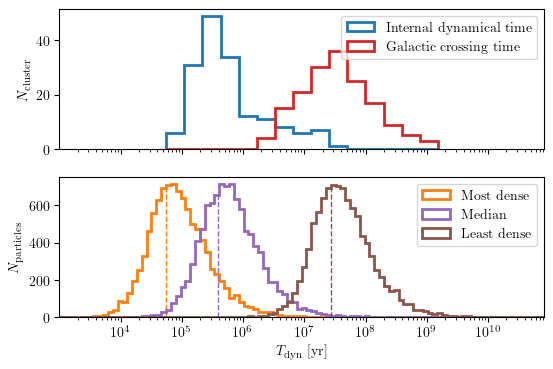

In [227]:
fig,axis=plt.subplots(2,1,figsize=(8.25-2,4),sharex=True, gridspec_kw={'height_ratios': [1, 1]})
axis[0].hist(tdyn.value, bins=binednges,  histtype='step', color='tab:blue', lw=2, label=r"$\mathrm{Internal~dynamical~time}$")
axis[0].hist(tcrossGCs.value, bins=binednges,  histtype='step', color='tab:red', lw=2, label=r"$\mathrm{Galactic~crossing~time}$")
axis[0].set_xscale('log')
axis[1].set_xlabel(r'$T_{\mathrm{dyn}}~[\mathrm{yr}]$', fontsize="medium")
axis[0].set_ylabel(r'$N_{\mathrm{cluster}}$', fontsize="medium")
ylims = axis[0].get_ylim()
axis[0].set_ylim(0, ylims[1])
# axis[0].set_xlim(3e4,5e9)
axis[0].legend(fontsize="medium", loc='best')

colors = ['tab:orange', 'tab:purple', 'tab:brown']
bin_ceneters = 0.5*(bins[1:] + bins[:-1])
for i in range(len(indexes)):
    index = indexes[i]
    xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
    rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
    tcrossP = rp/vp
    tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
    counts,_,_=axis[1].hist(tcrossP.value, bins=bins, histtype='step', lw=2, label=labels[i],color=colors[i])
    # find the counts at the median tdyn 
    myindex = np.argmin(np.abs(bin_ceneters - tdyn[index].value))
    axis[1].vlines(tdyn[index].value, 0, counts[myindex], color=colors[i], linestyle='--', lw=1, )
    print(np.median(tcrossP).value/tdyn[index].value)

axis[1].set_xlim(tmin.value, tmax.value)
axis[1].legend(fontsize="medium", loc='best')
axis[1].set_xscale('log')
axis[1].set_ylabel(r'$N_{\mathrm{particles}}$', fontsize="medium")

fig.savefig("../../images/GCsystemCharacteristicTimes.png", bbox_inches='tight', dpi=300)

# Crossing time within a cluster? 
What's a good timestep for the dynamics within a cluster?

In [223]:
factor = 1/100
index = indexes[-1]
NP = 1000
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
dt=factor*np.median(tcrossP)
print(dt*1e9,"years median")
print(factor*tdyn[index], "cluster")
# dt = 10**3 * 10**-9


419131.8997937864 years median
270716.6894763847 yr cluster


In [221]:
plummerRadius = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(GCdata['rh_m'][index].value)
Mass = GCdata['Mass'][index].value

integrationtime = 1*u.Gyr
integrationtime=integrationtime.to(tstrippy.Parsers.unitbasis['time']).value
NSTEPS = int(integrationtime/dt)
currentime = 0 

staticgalaxy = ["plummer", [G.value, Mass, plummerRadius]]
initialkinetmatics = [xp, yp, zp, vxp, vyp, vzp]
integrationparams = [currentime, dt, NSTEPS]
print(NSTEPS, NP)


3867 1000


In [205]:
RAM = NSTEPS*NP*6*8*u.byte
print(RAM.to(u.GB), "GB RAM required for this simulation"   )

0.0046404 Gbyte GB RAM required for this simulation


In [147]:
calc_time_per_step = 30e-9
print(calc_time_per_step*NSTEPS*NP, "seconds")

0.15399749999999998 seconds


In [ ]:
dts = tdyn*factor
nsteps = (5e9*u.year) / dts
nsteps = np.array([int(nstep.value) for nstep in nsteps])
np.sum(nsteps*calc_time_per_step*1e5)/60/60/24

np.float64(8.729680902777776)

In [193]:
5e9/5000

1000000.0

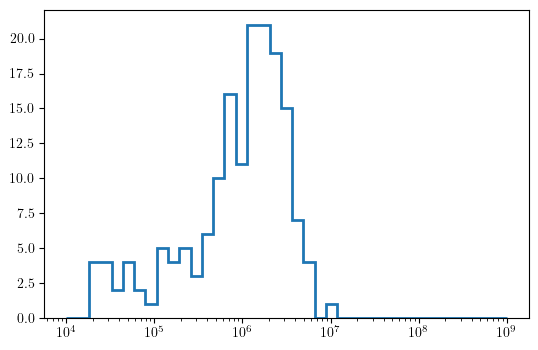

In [ ]:


bins = np.logspace(4,9,40)
fig,axis = plt.subplots(1, 1, figsize=(8.25-2, 4))
axis.hist(nsteps, bins=bins, histtype='step', lw=2, color='tab:blue')
axis.set_xscale('log')

In [148]:
tstrippy.integrator.deallocate()
tstrippy.integrator.setinitialkinematics(*initialkinetmatics)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparams)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(NSTEPS,NP)
# grab these final positions and velocities
xft,yft,zft = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
vxft,vyft,vzft = tstrippy.integrator.vxf.copy(), tstrippy.integrator.vyf.copy(), tstrippy.integrator.vzf.copy()
tstrippy.integrator.deallocate()
# now do it just to final positions
tstrippy.integrator.setinitialkinematics(*initialkinetmatics)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparams)
startime = datetime.datetime.now()
tstrippy.integrator.leapfrogtofinalpositions()
xf,yf,zf = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
vxf,vyf,vzf = tstrippy.integrator.vxf.copy(), tstrippy.integrator.vyf.copy(), tstrippy.integrator.vzf.copy()
tstrippy.integrator.deallocate()
endtime = datetime.datetime.now()
comptime = endtime - startime
print(f"Integration took {comptime} seconds")
tstrippy.integrator.deallocate()
step_time = comptime.total_seconds() / NSTEPS / NP
print(f"Step time: {step_time} seconds")

Integration took 0:00:00.118307 seconds
Step time: 2.3047192324550722e-08 seconds


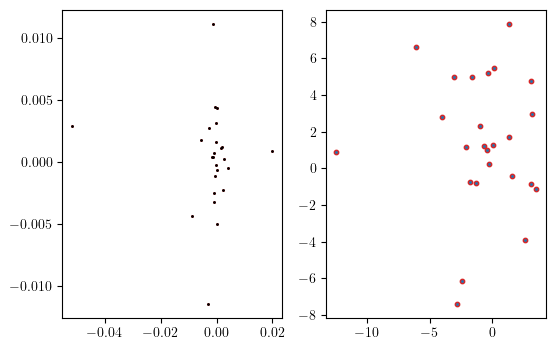

In [151]:
fig,axis=plt.subplots(1,2,figsize=(8.25-2,4),)
# axis.scatter(xp, yp, s=1, c='tab:blue', label=r"$\mathrm{Initial~positions}$")
# axis[0].scatter(xf[0], yf[0], s=10, c='tab:red', label=r"$\mathrm{Final~positions}$")
axis[0].scatter(xf, yf, s=1, c='tab:red', label=r"$\mathrm{Final~positions}$")
axis[0].scatter(xft, yft, s=1, c='k', label=r"$\mathrm{Final~positions~from~integrator}$"  )
# axis[0].scatter(xft[0], yft[0], s=10, c='k', label=r"$\mathrm{Final~positions~from~integrator}$"  )
# axis[0].set_aspect('equal')

axis[1].scatter(vxf, vyft, s=10, c='tab:red', label=r"$\mathrm{Final~velocities}$")
axis[1].scatter(vxf, vyft, s=1, c='tab:blue', label=r"$\mathrm{Final~velocities}$")


In [152]:
# measure the potential energy NOW 
phi = np.zeros_like(xt)
T = np.zeros_like(xt)
for i in range(NP):
    _,_,_,phi[i,:]=tstrippy.potentials.plummer(staticgalaxy[1],xt[i],yt[i],zt[i])
    T[i,:] = 0.5 * (vxt[i]**2 + vyt[i]**2 + vzt[i]**2)
E = T + phi
timestemps = np.linspace(0, integrationtime, NSTEPS+1)

E0=E[:,0]
E0=E0[:,np.newaxis]
errE = np.abs((E - E0) / E0)

In [153]:
# color based on how eccentric the orbit is
rp = np.sqrt(xp**2 + yp**2 + zp**2)
v = np.sqrt(vxp**2 + vyp**2 + vzp**2)
v_r = (xp*vxp + yp*vyp + zp*vzp) / rp
ecc_quick = (abs(v_r) / v)**2
ecc_quick

array([0.04527276, 0.92234232, 0.00611229, 0.01357459, 0.60311225,
       0.73901652, 0.28693407, 0.61962553, 0.03018971, 0.42589359,
       0.39645002, 0.07397919, 0.49158158, 0.49642284, 0.00346545,
       0.30525137, 0.82111418, 0.44156055, 0.08030323, 0.46976234,
       0.5845916 , 0.16478547, 0.41898903, 0.43984328, 0.23402414])

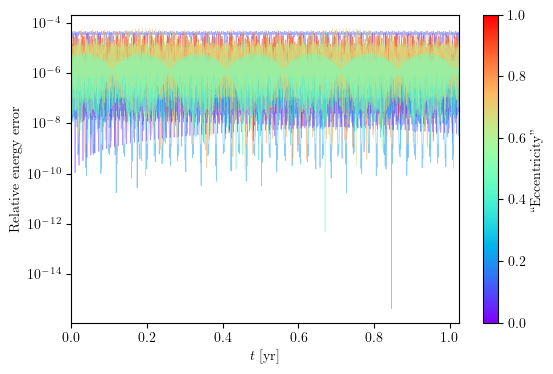

In [154]:
vmin = E0.min()
vmax = E0.max() 
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.rainbow
colors = cmap(norm(E[:,0]))
# color based on how eccentric the orbit is
rp = np.sqrt(xp**2 + yp**2 + zp**2)
v = np.sqrt(vxp**2 + vyp**2 + vzp**2)
v_r = (xp*vxp + yp*vyp + zp*vzp) / rp
ecc_quick = abs(v_r) / v
norm = mpl.colors.Normalize(vmin=0, vmax=1)
colors = cmap(ecc_quick)
NSKIP = 100
fig,axis = plt.subplots(1, 1, figsize=(8.25-2, 4))
for i in range(NP):
    axis.plot(timestemps[::NSKIP], errE[i,::NSKIP], lw=0.5, alpha=0.5,color=colors[i])
axis.set_yscale("log")
axis.set_xlabel(r'$t~[\mathrm{yr}]$', fontsize="medium")
axis.set_ylabel(r'$\mathrm{Relative~energy~error}$', fontsize="medium")
axis.set_xlim(0, integrationtime)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axis)
cbar.set_label(r'$``\mathrm{Eccentricity}"$', fontsize="medium")


In [252]:
np.median(tdyn).value

np.float64(389293.7774656306)

In [269]:
np.median(tdyn).value *factor

np.float64(3892.9377746563064)

In [277]:

factor = 1/100
kapprox = np.log2(5e9 / np.min(tdyn).value /factor) + 1
kUp = np.ceil(kapprox)
NSTEP = int(2**(kUp-1))
5e9/NSTEP

298.0232238769531

In [155]:

bins=np.logspace(-12,-2, 40)

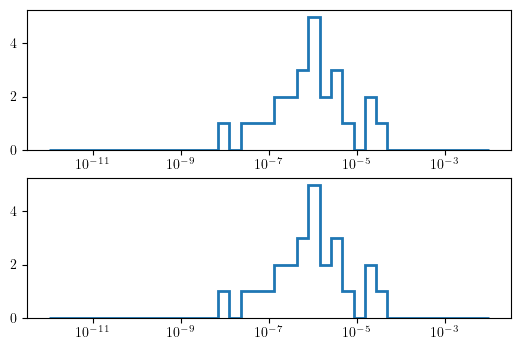

In [156]:
_,_,_,phi0=tstrippy.potentials.plummer(staticgalaxy[1],xp,yp,zp)
T0 = 0.5 * (vxp**2 + vyp**2 + vzp**2)
E0 = T0 + phi0
_,_,_,phif=tstrippy.potentials.plummer(staticgalaxy[1],xf,yf,zf)
Tf = 0.5 * (vxf**2 + vyf**2 + vzf**2)
Ef = Tf + phif

errEF = (Ef - E0)/E0

fig,axis=plt.subplots(2,1,figsize=(8.25-2,4))
axis[0].hist(np.abs(errEF), bins=bins, histtype='step', lw =2, color='tab:blue');
axis[1].hist(np.abs(errE[:,-1]), bins=bins, histtype='step', lw =2, color='tab:blue');
axis[0].set_xscale('log')
axis[1].set_xscale('log')

array([1.04854807e-10, 3.00834303e-07, 6.35794018e-09, 1.90498854e-07,
       3.94639146e-08, 6.43635495e-08, 5.60342666e-09, 1.35359980e-13,
       1.76045594e-09, 8.01884492e-09, 4.32152691e-09, 7.24260409e-09,
       2.08067946e-07, 1.63795224e-07, 1.27389502e-08, 3.71023825e-08,
       1.34393919e-08, 3.16166789e-10, 2.13231892e-08, 1.82079219e-08,
       9.59922030e-09, 1.41438488e-07, 5.24746023e-08, 8.12576564e-10,
       3.01151301e-07, 9.34696848e-08, 2.94102277e-07, 1.09740969e-09,
       9.26237314e-08, 1.29795213e-08, 3.67079479e-08, 5.04323019e-08,
       7.82424299e-08, 4.35971207e-07, 3.17989287e-07, 1.80362902e-08,
       1.71898255e-08, 2.34600376e-10, 4.22679867e-09, 1.05144055e-10,
       2.27734519e-07, 1.41618752e-08, 3.27020378e-09, 1.99674814e-07,
       1.22455946e-08, 2.03273277e-07, 2.75859485e-07, 3.02223291e-08,
       2.94358664e-08, 2.51443942e-08])